<h2> Lab 8

<h3> Exercise Set 1

(a) Scenario 1: You have a dataset of 300 documents containing numerical and text records of different nuclear units. Your task is to develop a model that can process similar documents and classify the data based on reactor design (PWR or BWR) and the length of the reactor life (< 40 years, > 40 years but < 60 years, > 60 years).

Needs to handle binary and continuous classification, small sample size, loss could be categorical crossentropy, how to rectify the two outputs?


(b) Scenario 2: You have a dataset of 5000 images of different pipes in a nuclear power plant unit. Your task is to develop a model that can predict the health of similar pipes and classify them into different grades: High, medium, low, or about to break.

Handles image classification, loss could be categorical crossentropy

(c) Scenario 3: You have a dataset of 100,000 time-dependent measurements of reactor pressure (MPa), fuel temperature (Kelvin), and mass flow rate of coolant (kg/s). Your task is to develop a model that predicts the coolant (water) level in the core in meters as a function of time

large dataset of time-dependent measurements, loss could be absolute squared error

(d) Scenario 4: You have a dataset of static nuclear data (cross-section) measurements taken from a nuclear laboratory for isotopes like U-235, U-238, Pu-239, Pu-240, and other actinides (Am, Cm) and fission products (Cs, Sm). Your task is to develop a model that can predict the value of $ k_{eff} $ based on these cross-section data.




<h3> Exercise Set 2

<h4>----------- Cut File -----------

(a) The correlation matrices of the input data (between the input themselves) and output data
(between the output themselves).
(b) The datafarme that shows the model ranking after tuning.
(c) The diagonal validation plot for an output of your choice (first output by default).
(d) The percent error plot for five outputs of your choice.
(e) The convergence of the Bayesian optimizer for the neural network.
(f) The neural network loss curve for the best neural network model.
(g) Discuss your observations of the performance of the methods and the results you
found.


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

In [2]:
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

In [3]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

In [4]:
#load the input and output dataframes from github
xdf=pd.read_csv('https://raw.githubusercontent.com/aims-umich/ners590data/main/teds_x.csv')
ydf=pd.read_csv('https://raw.githubusercontent.com/aims-umich/ners590data/main/teds_y.csv')

xnames=xdf.columns
ynames=ydf.columns

# Convert np arrays into xarrays
x = xr.DataArray(xdf, name="Input data", dims=["Samples", "Features"], coords={"Features":xnames})
y = xr.DataArray(ydf, name="Target data",dims=["Samples", "Features"], coords={"Features":ynames})

<h3>----------- Cut File -----------

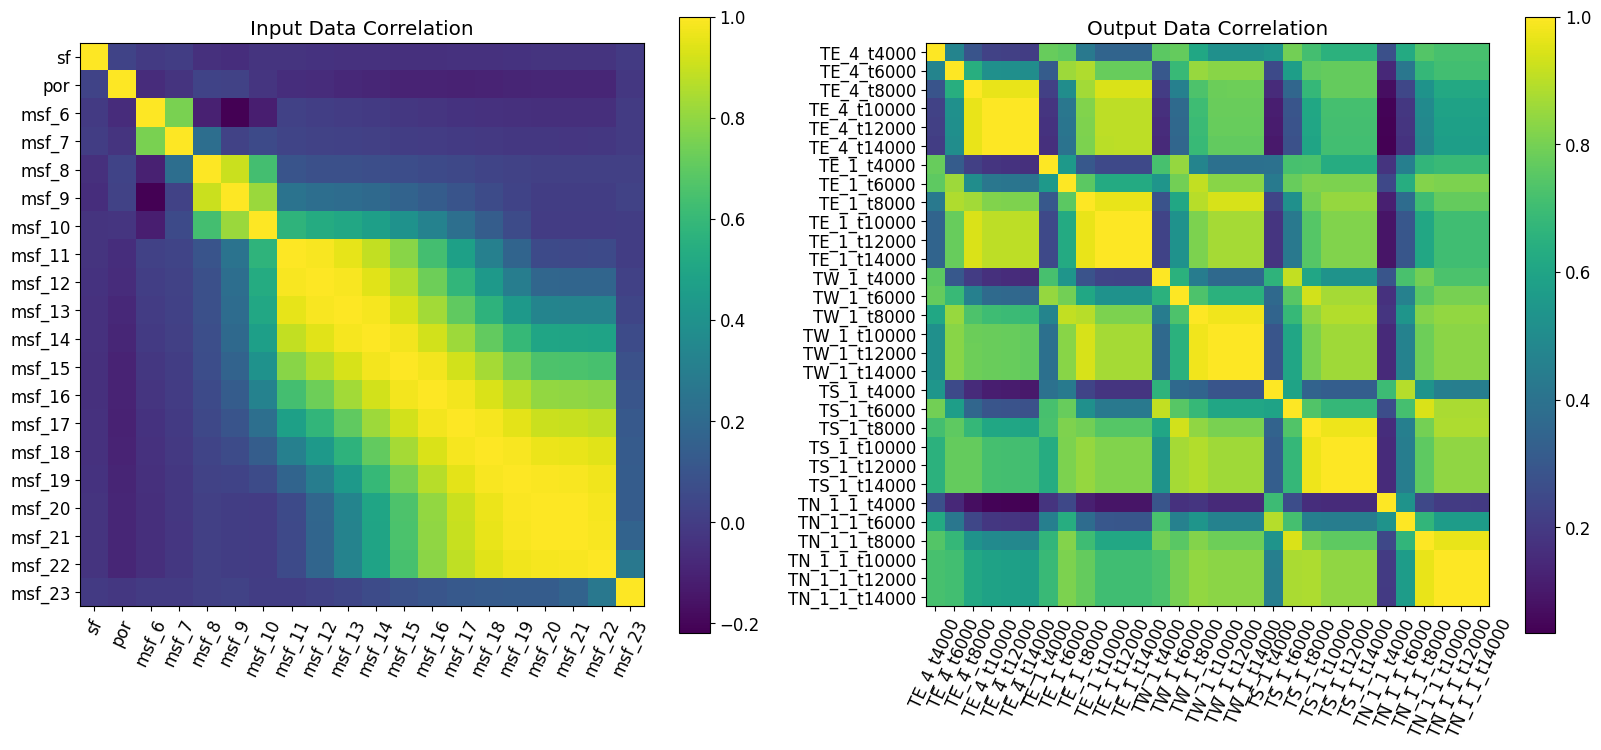

In [5]:
fig, ax = plt.subplots(1,2)
ax[0].set_title("Input Data Correlation")
ax[1].set_title("Output Data Correlation")
correlation_matrix(x, ax=ax[0], fig=fig)
correlation_matrix(y, ax=ax[1], fig=fig)
fig.set_figwidth(20)

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[x, y], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=250),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

In [7]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    #n_iter=200, 
    n_iter=3, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    #max_trials=50,
    max_trials=3,
    cv=5,
)

FNN: 100%|██████████| 15/15 [01:52<00:00,  7.49s/it]

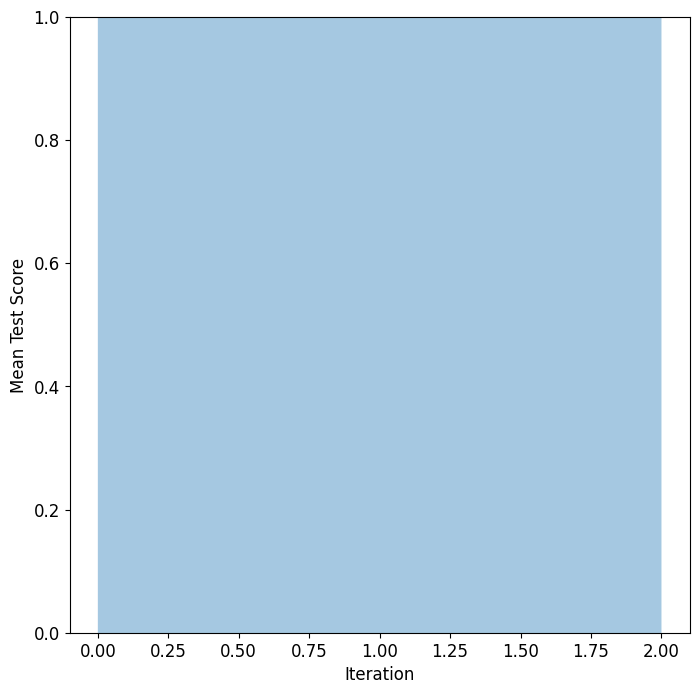

In [8]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])
plt.show()

In [9]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest),
    model_configs=[random_search_configs, bayesian_search_configs],
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 300}},
    },
    yscaler=yscaler,
)

postprocessor.metrics().drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
13,FNN,0.949034,2.629764,0.679278,4.766557,1.020876,0.949433,2.728465,0.704312,4.938362,1.035855
14,FNN,0.885196,4.149338,1.065669,7.931354,1.661870,0.884073,4.248496,1.085941,8.264197,1.690158
7,RF,0.910605,4.078831,1.032653,7.173395,1.546237,0.858289,5.557357,1.418245,9.857838,2.066468
11,KN,1.000000,0.000000,0.000000,0.000000,0.000000,0.842503,6.172775,1.581147,11.204141,2.333406
10,KN,0.905931,4.623752,1.172343,8.649041,1.785519,0.838367,6.422542,1.635217,11.758172,2.416430
12,KN,0.847459,6.110295,1.559322,10.766588,2.266322,0.831448,6.439018,1.650777,11.625170,2.423001
1,Lasso,0.828520,6.605993,1.697466,10.613230,2.251191,0.824377,6.730444,1.725373,10.874463,2.281301
0,Linear,0.833830,6.592265,1.686891,10.465970,2.198766,0.819348,6.874850,1.750941,10.983435,2.276701
2,Lasso,0.809735,6.801201,1.756493,11.166700,2.410118,0.811661,6.833488,1.766139,11.311240,2.420662
8,RF,0.852080,6.022399,1.552182,10.433018,2.223347,0.804572,7.296535,1.887390,12.579697,2.635689


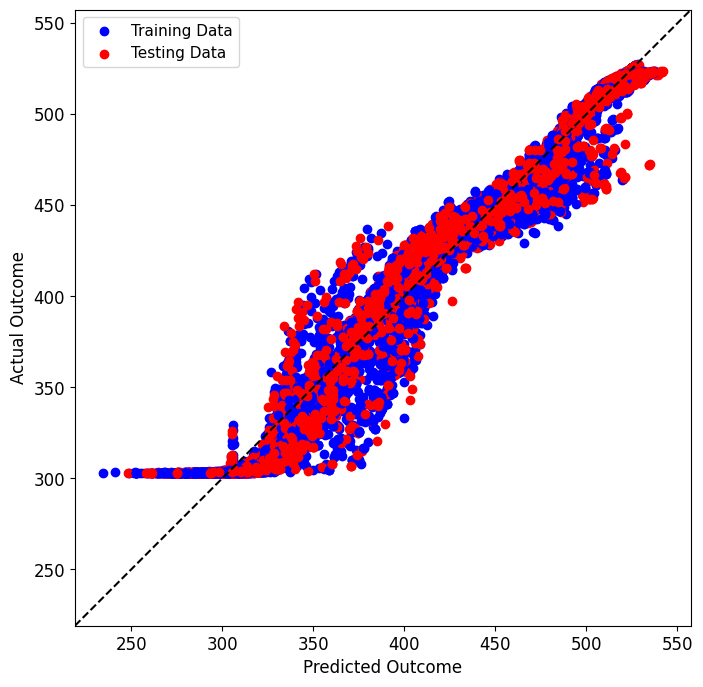

In [10]:
ax = postprocessor.diagonal_validation_plot(model_type='Linear')
plt.show()

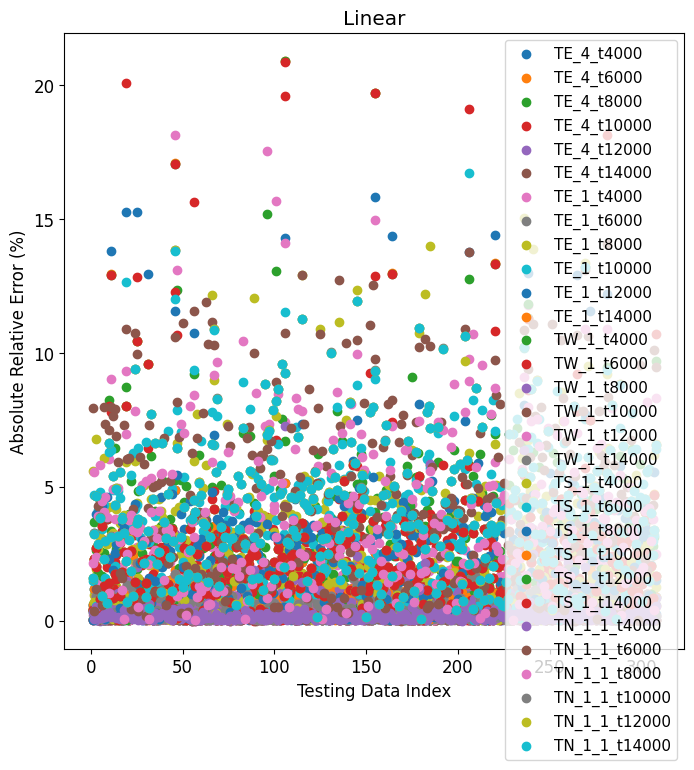

In [11]:
models = ["Linear", "Lasso", "DT", "RF", "KN"]
i = 0
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

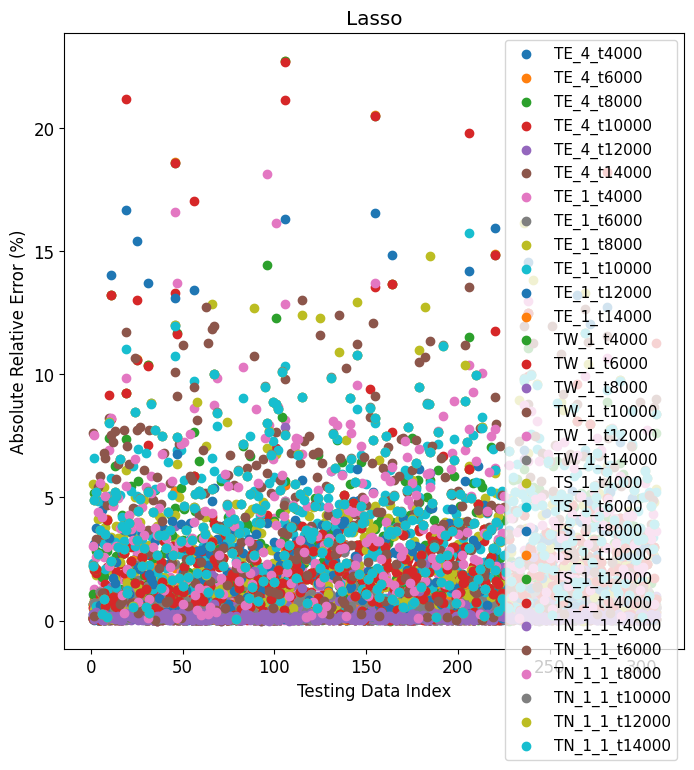

In [12]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

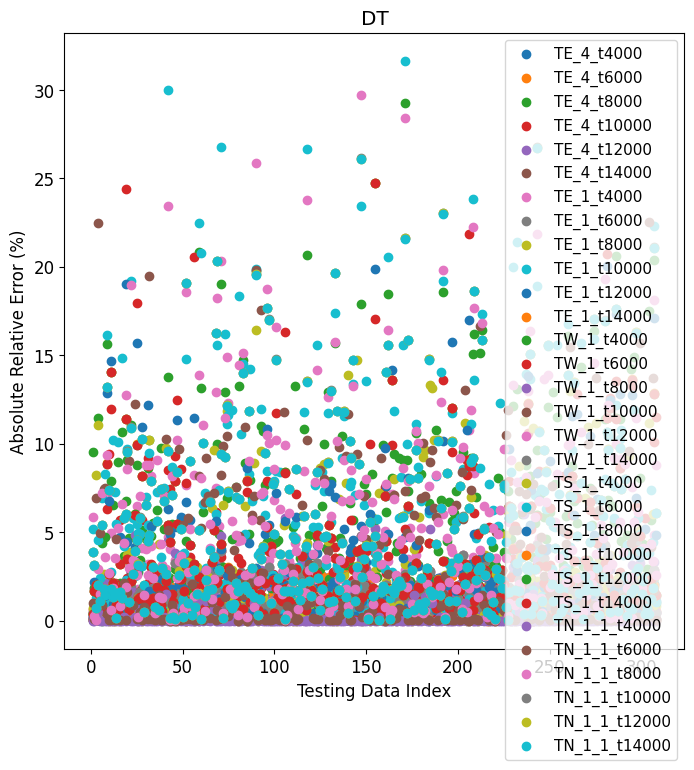

In [13]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

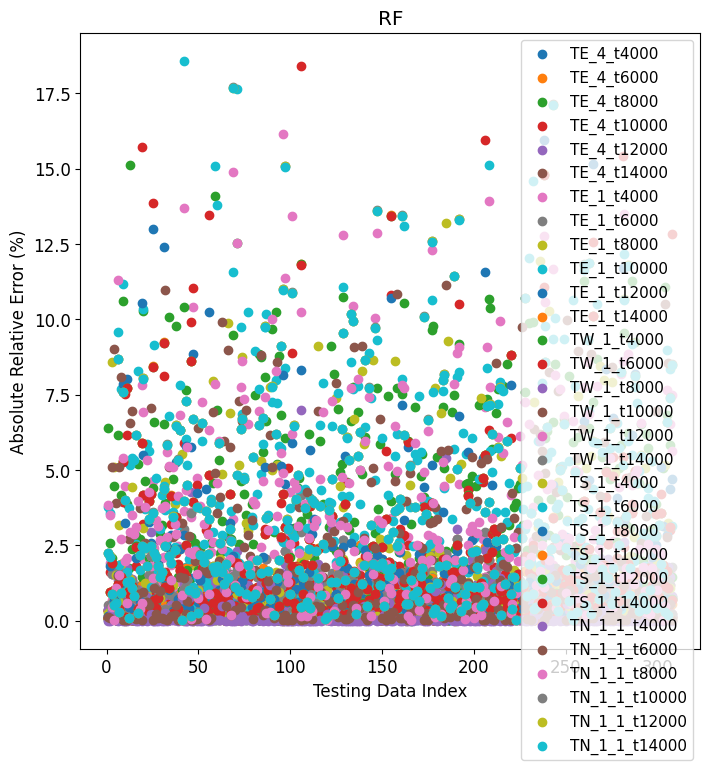

In [14]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

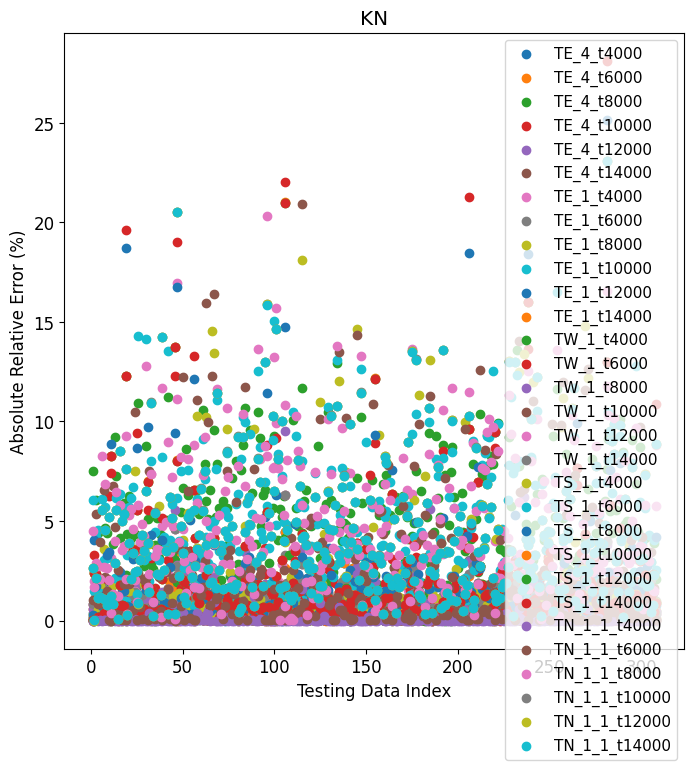

In [15]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

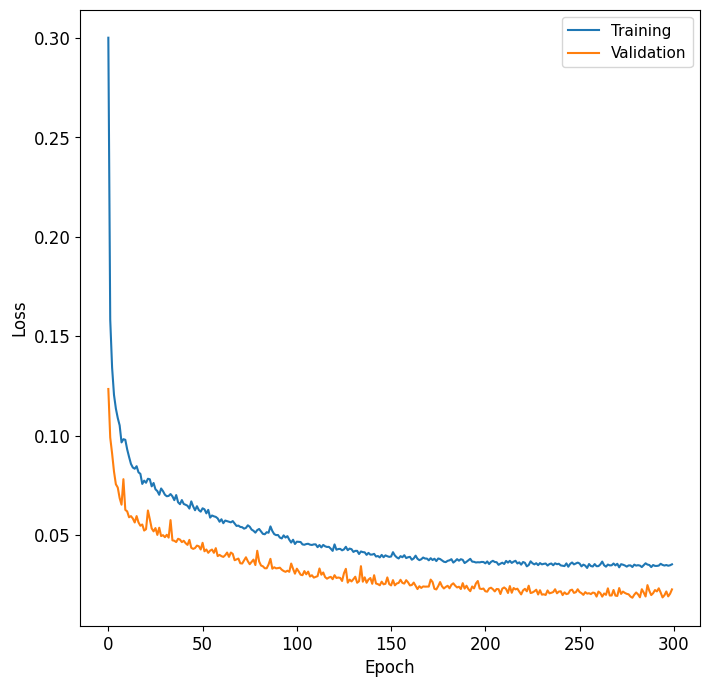

In [16]:
postprocessor.nn_learning_plot()
plt.show()

<h3> Exercise Set 3